# Mesa example: wealth model
----

In [1]:
import random
from mesa import Model, Agent
from mesa.time import RandomActivation

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Simplest possible model

In [3]:
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()

    def create_agents(self):
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()

    def run_model(self, steps):
        for i in range(steps):
            self.step() 

In [4]:
class MoneyAgent(Agent):

    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1

In [5]:
money_model = MoneyModel(100)

In [6]:
money_model.run_model(100)

(array([ 47.,  29.,  10.,   7.,   6.,   1.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

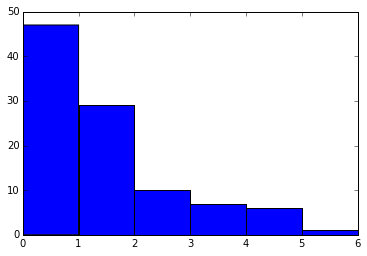

In [7]:
agent_wealth = [agent.wealth for agent in money_model.schedule.agents]
plt.hist(agent_wealth, bins=range(max(agent_wealth)+1))

# Adding a data collector

In [8]:
from mesa.datacollection import DataCollector

In [9]:
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()
        self.dc = DataCollector({"Gini": lambda m: m.compute_gini()},
                               {"Wealth": lambda a: a.wealth})

    def create_agents(self):
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        self.dc.collect(self)
        self.schedule.step()
        #self.dc.collect(self)
        
    def run_model(self, steps):
        for i in range(steps):
            self.step()
    
    def compute_gini(self):
        agent_wealths = [agent.wealth for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        N = self.num_agents
        B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
        return (1 + (1/N) - 2*B)


In [10]:
money_model = MoneyModel(100)
money_model.run_model(100)

In [11]:
agent_wealth = money_model.dc.get_agent_vars_dataframe()

In [12]:
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

In [13]:
agent_wealth.Wealth.argmax()

(71, 80)

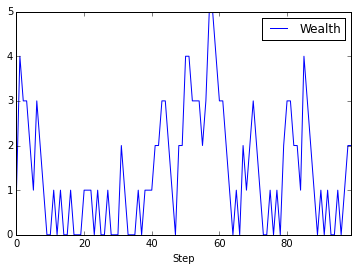

In [14]:
agent_wealth.xs(74, level="AgentID").plot()

In [15]:
gini = money_model.dc.get_model_vars_dataframe()

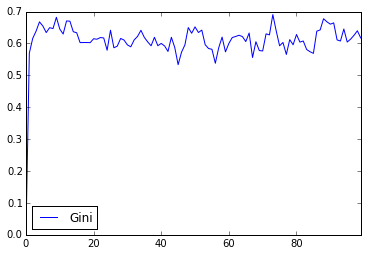

In [16]:
gini.plot()

# Adding a grid

In [17]:
from mesa.space import MultiGrid

In [18]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        self.move(model)
        if self.wealth > 0:
            self.give_money(model)

    def move(self, model):
        """Take a random step."""
        grid = model.grid
        possible_steps = grid.get_neighborhood(
            self.pos, moore=True, include_center=True)
        choice = random.choice(possible_steps)
        grid.move_agent(self, choice)

    def give_money(self, model):
        grid = model.grid
        pos = [self.pos]
        others = grid.get_cell_list_contents(pos)
        if len(others) > 1:
            other = random.choice(others)
            other.wealth += 1
            self.wealth -= 1

In [33]:
class Spatial_MoneyModel(MoneyModel):
    """A model with some number of agents."""
    def __init__(self, N, width, height, torus):
        self.grid = MultiGrid(height, width, torus)
        super().__init__(N)
        self.running = True

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

In [20]:
money_model = Spatial_MoneyModel(100, width=50, height=50, torus=True)

In [21]:
money_model.run_model(100)

In [22]:
gini = money_model.dc.get_model_vars_dataframe()

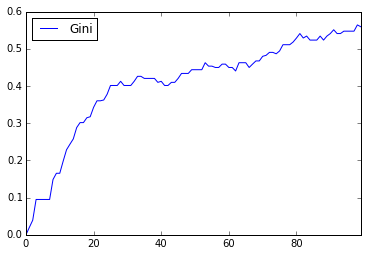

In [23]:
gini.plot()

In [24]:
import numpy as np

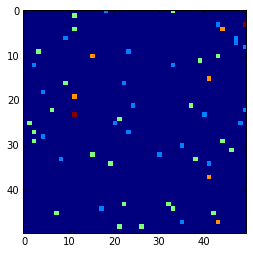

In [25]:
wealth_grid = np.zeros((money_model.grid.width, money_model.grid.height))

for cell in money_model.grid.coord_iter():
    cell_content, x, y = cell
    cell_wealth = sum(a.wealth for a in cell_content)
    wealth_grid[y][x] = cell_wealth
    
plt.imshow(wealth_grid, interpolation='nearest')

# Batch Run

In [26]:
from mesa.batchrunner import BatchRunner

In [40]:
params = {"height": 50, "width": 50, "torus": True,
         "N": range(100, 1000, 50)}

batch_run = BatchRunner(Spatial_MoneyModel, params, max_steps=100, iterations=10,
                       model_reporters={"Gini": lambda m: m.compute_gini()})

In [41]:
batch_run.run_all()

In [42]:
ginis = batch_run.get_model_vars_dataframe()

In [43]:
ginis.head()

,Gini,N,Run,height,torus,width
0,0.642520,500,88,50,True,50
1,0.678944,500,81,50,True,50
2,0.652432,500,86,50,True,50
3,0.627392,250,33,50,True,50
4,0.671960,550,97,50,True,50


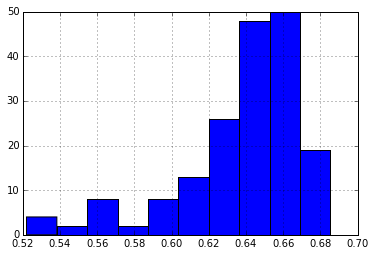

In [44]:
ginis.Gini.hist()

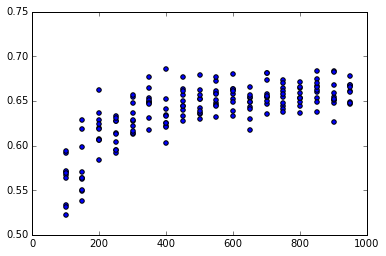

In [45]:
plt.scatter(ginis.N, ginis.Gini)